In [1]:
# работа с ОС
import os
import warnings
# работа с данными
import re
import pandas as pd
import numpy as np
from datetime import datetime
# ML
from sklearn.linear_model import LinearRegression
# визуализация данных
import plotly.io
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

warnings.filterwarnings("ignore")

In [2]:
def open_booking(filename: str) -> pd.DataFrame:
    """Функция открытия файла букинга.
       Для 4.3.1.
    """
    first_re = lambda x: True if re.fullmatch(r'\d{2}\.\d{2}\.\d{4} \d{2}:\d{2}:\d{2}', str(x)) else False
    second_re = lambda x: True if re.fullmatch(r'\d{0,5}\.0', str(x)) else False
    third_re = lambda x: True if re.fullmatch(r'\d{2}\.\d{2}\.\d{4}', str(x)) else False
    use_cols = ('Дата вылета рейса', 'Время вылета рейса', 'Номер рейса')
    dataset = pd.read_csv(filename, usecols=use_cols,
                          sep=';', on_bad_lines='skip', encoding='windows-1251', lineterminator='\n')
    dataset = dataset.dropna(how='any', axis=0)
    dataset = dataset.drop_duplicates()
    dataset = dataset.rename(columns={'Дата вылета рейса': 'FLTDATE',
                                      'Время вылета рейса': 'FLTTIME',
                                      'Номер рейса': 'FLTNUM'})
    dataset = dataset[(dataset['FLTTIME'].apply(first_re)) &
                      (dataset['FLTNUM'].apply(second_re)) &
                      (dataset['FLTDATE'].apply(third_re))]
    dataset['FLTNUM'] = dataset['FLTNUM'].astype(float).astype(int)
    dataset['FLTTIME'] = pd.to_datetime(dataset['FLTTIME'], format='%d.%m.%Y %H:%M:%S', errors='coerce')
    dataset['FLTDATE'] = pd.to_datetime(dataset['FLTDATE'], format='%d.%m.%Y', errors='coerce')
    return dataset

def open_inventory(filename: str, start_date: str, end_date: str, use_cols: tuple = None) -> pd.DataFrame:
    """Функция открытия файла inventory.
       Для 4.3.1.
    """
    result = []
    for date in pd.date_range(start=start_date, end=end_date, freq='D'):
        file_name = fr'{filename}{date.strftime("%d%m%Y")}.csv'
        try:
            current_data = pd.read_csv(file_name, sep=';', usecols=use_cols)
            current_data['FLTDATE'] = pd.to_datetime(current_data['FLTDATE'], format='%d.%m.%Y', errors='coerce')
            current_data = current_data.drop_duplicates()
            result.append(current_data)
        except FileNotFoundError:
            continue
    return pd.concat(result, ignore_index=True)

In [10]:
def get_flight(booking: pd.DataFrame, inventory: pd.DataFrame,
               fltnum: int, date: datetime, flttime: pd.Timedelta) -> (str, pd.DataFrame):
    """Получение данных конкретного рейса"""
    departure = date + flttime
    flight = booking[(booking['FLTNUM'] == fltnum) & (booking['FLTTIME'] == departure)]
    print(f"Рейс:", fltnum, departure)
    flight = pd.merge(flight, inventory, left_on=['FLTNUM', 'FLTDATE'],
                                         right_on=['SFLTNO', 'FLTDATE'])
    flight = flight.dropna(how='any', axis=0)
    flight = flight.drop(columns=['SFLTNO', 'FLTDATE'])
    flight = flight.drop_duplicates()
    print(f"Данных: {flight.shape[0]:_}")
    return f"{fltnum}, {departure}", flight

def flight_graph(flight: pd.DataFrame, flight_name: str, days: int) -> None:
    """График бронирования билетов для всего рейса"""
    flight = pd.DataFrame(flight.groupby(by='DTD')['PASS'].sum()).reset_index()
    flight['DTD'] = -flight['DTD']
    fig, ax = plt.subplots(figsize=(4, 2))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=flight[['DTD', 'PASS']].values[:days],
                     colLabels=flight.columns,
                     colColours=["grey"] * 2,
                     cellColours=[["lightblue", 'w'] for _ in range(days)],
                     loc='center',
                     cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)
    plt.show()
    fig = px.line(flight, x="DTD", y="PASS", title=f"График спроса для рейса {flight_name}")
    fig.update_layout(xaxis_title="День до вылета", yaxis_title="Количество забронированных билетов")
    fig.update_xaxes(tickvals=list(range(flight['DTD'].min(), 2, 14)))
    plotly.io.show(fig)

def cabin_graph(flight: pd.DataFrame, flight_name: str, days: int) -> None:
    """График продаж по кабинам"""
    flight = pd.DataFrame(flight.groupby(by=['SCL', 'DTD'])['PASS'].sum()).reset_index()
    flight['DTD'] = -flight['DTD']
    cabin_C = flight[flight['SCL'] == 'C'].reset_index(drop=True)
    cabin_Y = flight[flight['SCL'] == 'Y'].reset_index(drop=True)
    to_show = np.array([cabin_C['DTD'].to_list()[:days],
                        cabin_C['PASS'].to_list()[:days],
                        cabin_Y['PASS'].to_list()[:days]])
    to_show = np.transpose(to_show)
    fig, ax = plt.subplots(figsize=(4, 2))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=to_show,
                     colLabels=['DTD', 'PASS_C', 'PASS_Y'],
                     colColours=["grey"] * 3,
                     cellColours=[["lightblue", 'w', 'w'] for _ in range(days)],
                     loc='center',
                     cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)
    plt.show()
    fig = px.line(flight, x="DTD", y="PASS", color='SCL',
                  title=f"График спроса для рейса {flight_name}")
    fig.update_layout(xaxis_title="День до вылета", yaxis_title="Количество забронированных билетов")
    fig.update_xaxes(tickvals=list(range(flight['DTD'].min(), 2, 14)))
    plotly.io.show(fig)

def class_graph(flight: pd.DataFrame, flight_name: str, days: int) -> None:
    """График продаж по классам"""
    flight = pd.DataFrame(flight.groupby(by=['SCL', 'BCL', 'DTD'])['PASS'].sum())
    flight = flight.reset_index()
    flight['DTD'] = -flight['DTD']
    to_show = pd.DataFrame(flight.groupby(by=['BCL', 'DTD'])['PASS'].sum()).reset_index()
    dtds = to_show['DTD'].unique().reshape(-1, 1)[::-1]
    to_show = to_show.pivot(columns='BCL', values='PASS')
    to_show_cols = np.concatenate((['DTD'], to_show.columns))
    to_show = to_show.values
    to_show = np.transpose(to_show)
    to_show = np.array([i[~np.isnan(i)] for i in to_show])
    to_show = np.transpose(to_show)
    to_show = np.flipud(to_show)
    to_show = np.concatenate((dtds, to_show), axis=1)
    to_show = to_show.astype(int)
    fig, ax = plt.subplots()
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=to_show[:days],
                     colLabels=to_show_cols,
                     colColours=["grey"] * len(to_show_cols),
                     cellColours=[["lightblue"] + ['w'] * (len(to_show_cols) - 1) for _ in range(days)],
                     loc='center',
                     cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)
    plt.show()
    cabin_C = flight[flight['SCL'] == 'C']
    cabin_Y = flight[flight['SCL'] == 'Y']
    fig = px.line(cabin_C, x="DTD", y="PASS", color='BCL',
                  title=f"График спроса для рейса {flight_name} кабины C")
    fig.update_layout(xaxis_title="День до вылета", yaxis_title="Количество забронированных билетов")
    fig.update_xaxes(tickvals=list(range(flight['DTD'].min(), 2, 14)))
    fig.show()
    fig = px.line(cabin_Y, x="DTD", y="PASS", color='BCL',
                  title=f"График спроса для рейса {flight_name} кабины Y")
    fig.update_layout(xaxis_title="День до вылета", yaxis_title="Количество забронированных билетов")
    fig.update_xaxes(tickvals=list(range(flight['DTD'].min(), 2, 14)))
    plotly.io.show(fig)

# 4.3.1	Функция «Динамики бронирования вылетевшего рейса»

In [4]:
booking = open_booking(r"F:\new_datas\декабрь 2019.csv")
columns = ('DTD', 'SFLTNO', 'FLTDATE', 'PASS', 'SCL', 'BCL')
inv = open_inventory(r"F:\new_datas\inventory\INV", '2019-12-01', '2019-12-02', columns)

In [5]:
flight_name, flight = get_flight(booking, inv, 46,
                                 datetime.strptime('2019-12-01', '%Y-%m-%d'),
                                 pd.Timedelta('23:50:00'))
flight.head(1)

Рейс: 46 2019-12-01 23:50:00
Данных: 5_654


,FLTTIME,FLTNUM,DTD,SCL,BCL,PASS
0,2019-12-01 23:50:00,46,255,C,I,0


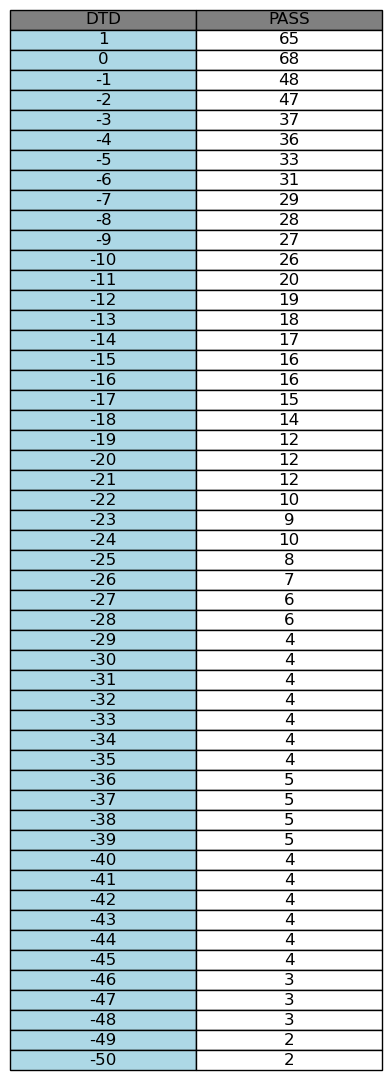

In [11]:
flight_graph(flight, flight_name, 52)

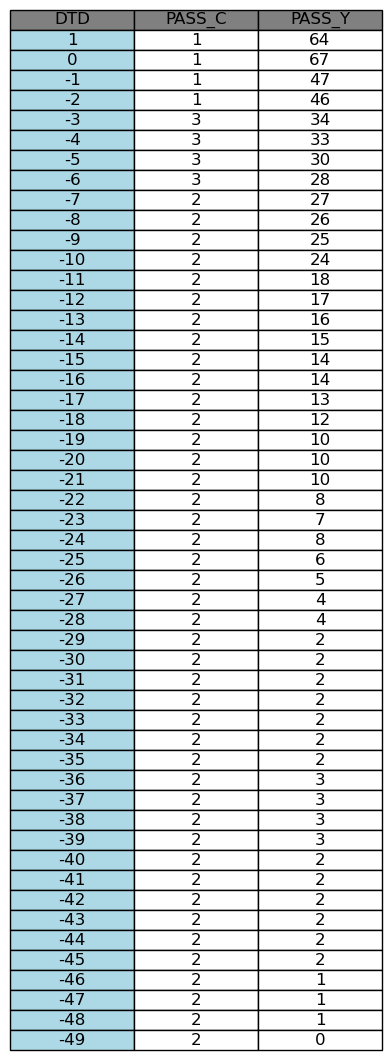

In [12]:
cabin_graph(flight, flight_name, 51)

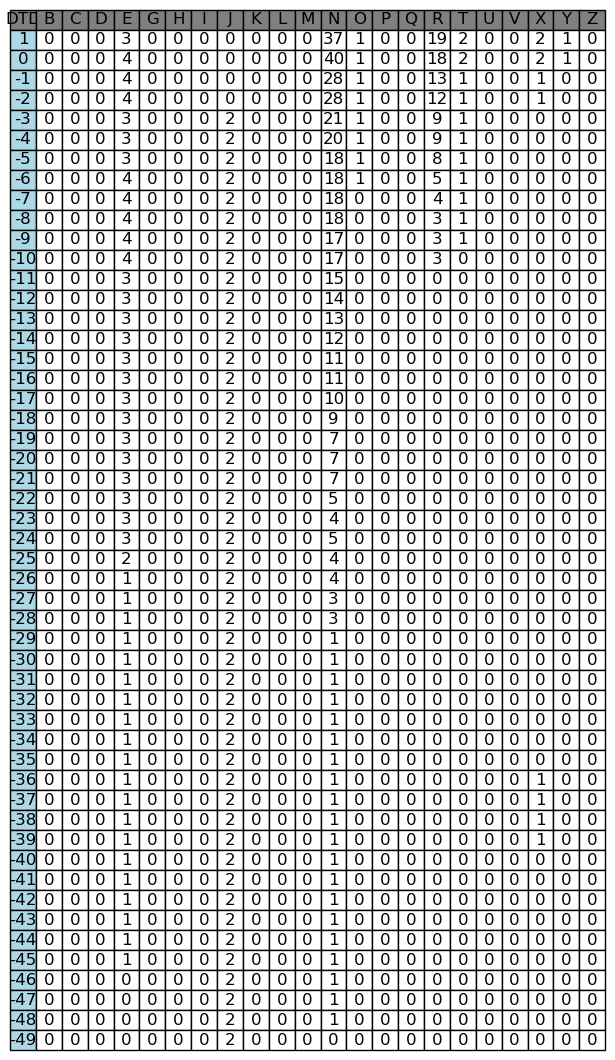

In [14]:
class_graph(flight, flight_name, 51)

# 4.3.2	Функция «Динамики бронирования продаваемого рейса»

In [8]:
%%time
flight_name, flight = get_flight(1126,
                                 datetime.strptime('2018-01-01', '%Y-%m-%d'),
                                 pd.Timedelta('15:40:00'))

Рейс: 1126 2018-01-01 15:40:00
Данных: 4_136
Wall time: 1.11 s


In [9]:
def draw_graph_with_regression_for_all_flight(Data, forecast_after_point):
    """График продаж до дня DTD=i и прогнозирования роста продаж регрессией"""
    filtered_data = Data.copy()
    filtered_data = pd.DataFrame(filtered_data.groupby(by='DTD')['PASS_BK'].sum()).reset_index()
    filtered_data.sort_values(by='DTD', inplace=True)
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    # Исторические данные
    fig.add_trace(go.Scatter(x=filtered_data['DTD'], y=filtered_data['PASS_BK'],
                             mode='markers+lines', name='Исторические данные'))
    # Разделение данных на исторические и будущие точки
    historical_data = filtered_data[filtered_data['DTD'] <= forecast_after_point]
    future_data = filtered_data[filtered_data['DTD'] > forecast_after_point]
    # Прогнозирование с использованием линейной регрессии
    X = historical_data['DTD'].values.reshape(-1, 1)
    y = historical_data['PASS_BK'].values
    reg = LinearRegression().fit(X, y)
    # Построение линии регрессии
    x_forecast = np.arange(forecast_after_point, -1, -1).reshape(-1, 1)
    y_forecast = reg.predict(x_forecast)
    fig.add_trace(go.Scatter(x=x_forecast.flatten(), y=y_forecast, mode='lines',
                             line=dict(dash='dash'), name='Прогноз'))
    fig.update_xaxes(title_text='Дни до вылета')
    fig.update_yaxes(title_text='Прогноз', secondary_y=True)
    fig.update_yaxes(title_text='Количество пассажиров', secondary_y=False)
    fig.update_layout(title_text=f'График продаж по дням для всего рейса с прогнозом после DTD={forecast_after_point}',
                      xaxis=dict(autorange="reversed"), showlegend=True)
    fig.update_xaxes(tickvals=list(range(filtered_data['DTD'].max(), -2, -14)))
    
    fig.show()

In [10]:
draw_graph_with_regression_for_all_flight(flight, 50)

In [11]:
def draw_graph_with_regression_for_all_cabins(Data, forecast_after_point):
    filtered_data = Data.copy()
    filtered_data = pd.DataFrame(filtered_data.groupby(by=['SSCL1', 'DTD'])['PASS_BK'].sum()).reset_index()
    filtered_data.sort_values(by='DTD', inplace=True)
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    # Уникальные значения SSCL1
    unique_sscl1_values = filtered_data['SSCL1'].unique()
    for sscl1_value in unique_sscl1_values:
        # Фильтрация данных по текущему значению SSCL1
        current_sscl1_data = filtered_data[filtered_data['SSCL1'] == sscl1_value]
        # Исторические данные
        fig.add_trace(go.Scatter(x=current_sscl1_data['DTD'], y=current_sscl1_data['PASS_BK'],
                                 mode='markers+lines', name=f'Исторические данные ({sscl1_value})'))
        # Разделение данных на исторические и будущие точки
        historical_data = current_sscl1_data[current_sscl1_data['DTD'] <= forecast_after_point]
        future_data = current_sscl1_data[current_sscl1_data['DTD'] > forecast_after_point]
        # Прогнозирование с использованием линейной регрессии
        X = historical_data['DTD'].values.reshape(-1, 1)
        y = historical_data['PASS_BK'].values
        reg = LinearRegression().fit(X, y)
        # Построение линии регрессии
        x_forecast = np.arange(forecast_after_point, -1, -1).reshape(-1, 1)
        y_forecast = reg.predict(x_forecast)
        fig.add_trace(go.Scatter(x=x_forecast.flatten(), y=y_forecast, mode='lines',
                                 line=dict(dash='dash'), name=f'Прогноз ({sscl1_value})'))
    fig.update_xaxes(title_text='Дни до вылета')
    fig.update_yaxes(title_text='Количество пассажиров', secondary_y=False)
    fig.update_yaxes(title_text='Прогноз', secondary_y=True)
    
    fig.update_layout(title_text=f'График продаж по дням для всего рейса и его кабин с прогнозом после DTD={forecast_after_point}',
                      xaxis=dict(autorange="reversed"), showlegend=True)
    fig.update_xaxes(tickvals=list(range(filtered_data['DTD'].max(), -2, -14)))
    fig.show()

In [12]:
draw_graph_with_regression_for_all_cabins(flight, forecast_after_point=50)

In [15]:
def draw_graph_with_regression_for_all_cabins_and_classes(Data, forecast_after_point):
    filtered_data = Data.copy()
    filtered_data = pd.DataFrame(filtered_data.groupby(by=['SSCL1', 'SEG_CLASS_CODE', 'DTD'])['PASS_BK'].sum()).reset_index()
    filtered_data.sort_values(by='DTD', inplace=True)

    fig = make_subplots(specs=[[{"secondary_y": True}]])
    # Уникальные значения SSCL1
    unique_sscl1_values = filtered_data['SSCL1'].unique()
    
    for sscl1_value in unique_sscl1_values:
        # Фильтрация данных по текущему значению SSCL1
        current_sscl1_data = filtered_data[filtered_data['SSCL1'] == sscl1_value]
        # Уникальные значения SEG_CLASS_CODE
        unique_seg_class_values = current_sscl1_data['SEG_CLASS_CODE'].unique()
        for seg_class_value in unique_seg_class_values:
            # Фильтрация данных по текущему значению SEG_CLASS_CODE
            current_seg_class_data = current_sscl1_data[current_sscl1_data['SEG_CLASS_CODE'] == seg_class_value]
            # Исторические данные
            fig.add_trace(go.Scatter(x=current_seg_class_data['DTD'],
                                     y=current_seg_class_data['PASS_BK'],
                                     mode='markers+lines',
                                     name=f'Исторические данные ({sscl1_value}, {seg_class_value})'))
            # Разделение данных на исторические и будущие точки
            historical_data = current_seg_class_data[current_seg_class_data['DTD'] <= forecast_after_point]
            future_data = current_seg_class_data[current_seg_class_data['DTD'] > forecast_after_point]
            # Прогнозирование с использованием линейной регрессии
            X = historical_data['DTD'].values.reshape(-1, 1)
            y = historical_data['PASS_BK'].values
            reg = LinearRegression().fit(X, y)
            # Построение линии регрессии
            x_forecast = np.arange(forecast_after_point, -1, -1).reshape(-1, 1)
            y_forecast = reg.predict(x_forecast)
            fig.add_trace(go.Scatter(x=x_forecast.flatten(), y=y_forecast, mode='lines', line=dict(dash='dash'),
                                     name=f'Прогноз ({sscl1_value}, {seg_class_value})'))
    fig.update_xaxes(title_text='Дни до вылета')
    fig.update_yaxes(title_text='Количество пассажиров', secondary_y=False)
    fig.update_yaxes(title_text='Прогноз', secondary_y=True)
    
    fig.update_layout(title_text=f'График продаж по дням для всего рейса с прогнозом после DTD={forecast_after_point}',
                      xaxis=dict(autorange="reversed"), showlegend=True)
    fig.update_xaxes(tickvals=list(range(filtered_data['DTD'].max(), -2, -14)))
    fig.show()

In [16]:
draw_graph_with_regression_for_all_cabins_and_classes(flight, forecast_after_point=50)